In [183]:
import numpy as np

import scipy.stats
import scipy.io as sio
from scipy import io
from sklearn.metrics import roc_auc_score, average_precision_score
import time
import cPickle as pic

In [184]:
import itertools
import glob
import os
import sys
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from scipy import sparse
import seaborn as sns
sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

In [185]:
import cofacto4 as cof
import rec_eval

In [186]:
'''Bibtex = sio.loadmat("bibtex.mat")
#print type(Bibtex)
#print Bibtex
X_tr = Bibtex["X_tr"].todense().tolist()
X_te = Bibtex["X_te"].todense().tolist()
Y_tr = Bibtex["Y_tr"].todense().tolist()
Y_te = Bibtex["Y_te"].todense().tolist()'''

'Bibtex = sio.loadmat("bibtex.mat")\n#print type(Bibtex)\n#print Bibtex\nX_tr = Bibtex["X_tr"].todense().tolist()\nX_te = Bibtex["X_te"].todense().tolist()\nY_tr = Bibtex["Y_tr"].todense().tolist()\nY_te = Bibtex["Y_te"].todense().tolist()'

In [187]:
datas = {'bib':'bibtex.mat', 'del':'delicious_1.mat', 'eur':'eurlex_1.mat', 'med':'mediamill_1.mat'} 

In [188]:
path = datas['del']
Dataset = sio.loadmat(path)
#print type(Bibtex)
#print Bibtex
X_tr = Dataset["X_tr"].todense().tolist()
X_te = Dataset["X_te"].todense().tolist()
Y_tr = Dataset["Y_tr"].todense().tolist()
Y_te = Dataset["Y_te"].todense().tolist()

In [189]:
X_tr = np.asarray(X_tr)
k = X_tr.shape[1]
Y_tr = np.asarray(Y_tr)
X_te = np.asarray(X_te)
Y_te = np.asarray(Y_te)

In [190]:
Y_tr_0 = Y_tr[:, : 100] 

In [191]:
'''path = datas['med']
Dataset = sio.loadmat(path)
#print type(Bibtex)
#print Bibtex
X_tr = Dataset["X_tr"]
X_te = Dataset["X_te"]
Y_tr = Dataset["Y_tr"]
Y_te = Dataset["Y_te"]'''

'path = datas[\'med\']\nDataset = sio.loadmat(path)\n#print type(Bibtex)\n#print Bibtex\nX_tr = Dataset["X_tr"]\nX_te = Dataset["X_te"]\nY_tr = Dataset["Y_tr"]\nY_te = Dataset["Y_te"]'

## Construct co-occurance matrix

In [192]:
Y_tr.shape

(12568, 983)

In [193]:
M_t = np.dot(Y_tr.T, Y_tr)
#M_t /= np.sum(M_t, axis=0, dtype=float, keepdims=True)
#M_ns = M_t

In [194]:
M_t = sparse.csr_matrix(M_t)
float(M_t.nnz) / np.prod(M_t.shape)

0.3331953483895605

In [195]:
def get_row(Y, i):
    lo, hi = Y.indptr[i], Y.indptr[i + 1]
    return lo, hi, Y.data[lo:hi], Y.indices[lo:hi]

In [196]:
count = np.asarray(M_t.sum(axis=1)).ravel()

In [197]:
n_pairs = M_t.data.sum()

## Construct PMI

In [198]:
M = M_t.copy()
for i in xrange(M.shape[0]):
    lo, hi, d, idx = get_row(M, i)
    M.data[lo:hi] = np.log(d * n_pairs / (count[i] * count[idx]))

In [199]:
M.data[M.data < 0] = 0
M.eliminate_zeros()

In [200]:
Y_tr = sparse.csr_matrix(Y_tr)
Y_te = sparse.csr_matrix(Y_te)
#M = sparse.csr_matrix(M)

In [201]:
float(M.nnz) / np.prod(M.shape)

0.18299804716808327

## SPPMI

In [202]:
# number of negative samples
k_ns = 10

M_ns = M.copy()

if k_ns > 1:
    offset = np.log(k_ns)
else:
    offset = 0.
    
M_ns.data -= offset
M_ns.data[M_ns.data < 0] = 0
M_ns.eliminate_zeros()

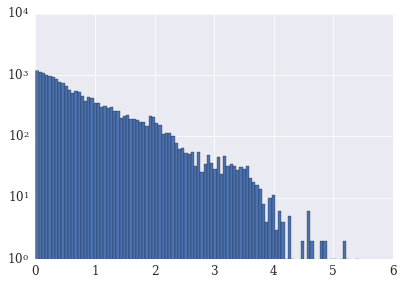

In [203]:
plt.hist(M_ns.data, bins=100)
plt.yscale('log')
pass

In [204]:
float(M_ns.nnz) / np.prod(M_ns.shape)

0.020283786734610454

## Train

In [269]:
scale = 0.03
n_components = 100
max_iter = 10
n_jobs = 8
lam_theta = 1e-5 * scale
lam_beta = 1e-5 * scale
lam_gamma = 1e-3
lam_W = 1e-3
c0 = 1. * scale
c1 = 100. * scale
save_dir = "param"

In [270]:
reload(cof)
coder = cof.CoFacto(n_components=n_components, max_iter=max_iter, batch_size=5000, init_std=0.01, n_jobs=n_jobs, 
                        random_state=98765, save_params=True, save_dir=save_dir, early_stopping=True, verbose=True, 
                        lambda_theta=lam_theta, lambda_beta=lam_beta, lambda_gamma=lam_gamma, lambda_W=lam_W, c0=c0, c1=c1)

In [271]:
coder.X_te = X_te
coder.Y_te = Y_te
print coder.lam_theta, coder.lam_beta, coder.lam_gamma, coder.lam_W

3e-07 3e-07 0.001 0.001


ITERATION #0
	Updating user factors...u: 0
u: 1000
u: 2000
u: 3000
u: 4000
u: 5000
u: 6000
u: 7000
u: 8000
u: 9000
u: 10000
u: 11000
u: 12000
	Updating user factors: time=1744.67
	Updating item factors: time=1.18
	Updating context factors: time=0.60
	Updating W factors: time=0.09
	Updating bias terms: time=0.86
Pre@1: 0.140798952194 	Pre@3: 0.119842829077 	Pre@5: 0.107334643091
ITERATION #1
	Updating user factors...u: 0
u: 1000
u: 2000
u: 3000
u: 4000
u: 5000
u: 6000
u: 7000
u: 8000
u: 9000
u: 10000
u: 11000
u: 12000
	Updating user factors: time=1737.29
	Updating item factors: time=1.13
	Updating context factors: time=0.59
	Updating W factors: time=0.09
	Updating bias terms: time=0.85
Pre@1: 0.513097576948 	Pre@3: 0.449465182275 	Pre@5: 0.405173542895
ITERATION #2
	Updating user factors...u: 0
u: 1000
u: 2000
u: 3000
u: 4000
u: 5000
u: 6000
u: 7000
u: 8000
u: 9000
u: 10000
u: 11000
u: 12000
	Updating user factors: time=1765.92
	Updating item factors: time=0.91
	Updating context factors

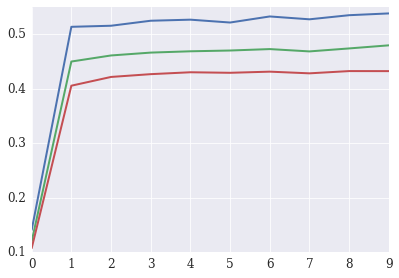

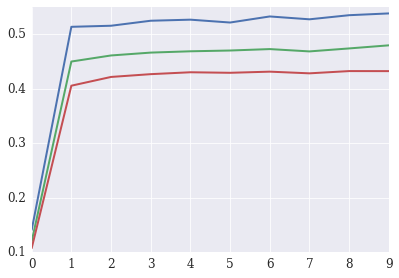

CoFacto(batch_size=5000, dtype='float32', early_stopping=True, init_std=0.01,
    max_iter=10, n_components=100, n_jobs=8, random_state=98765,
    save_dir='param', save_params=True, verbose=True)

In [272]:
coder.fit(Y_tr, M_ns, X_tr, vad_data = None, batch_users=5000, k=100)

In [ ]:
print np.asarray(coder.pre[np.argmax(np.asarray(coder.pre)[:,0])])*100, max(np.asarray(coder.pre)[:,1]), max(np.asarray(coder.pre)[:,2])

In [ ]:
coder.tot_t / 10

In [ ]:
print path+": "+str(np.sum(coder.tot_t)/max_iter)+"\tk: "+str(n_components)

In [ ]:
ups = ['theta: ', 'beta: ', 'gamma: ', 'W', 'bias-terms: ']

In [ ]:
print np.around(np.sum(coder.tot_t, axis=0)/10, decimals=3)

In [ ]:
coder.tm